In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt
import random

shap.initjs()

In [2]:
# ============================
# 1. Load cleaned data
# ============================

data_path = "./data/processed/financial_report_bank_zscore_clean.csv"
df = pd.read_csv(data_path)

print("Shape data:", df.shape)
print(df.head())

Shape data: (1812, 27)
  symbol  calendar_year period    time       size       der       dar  \
0   AGRO           2023     Q4  2023Q4  30.151990  0.158755  0.043646   
1   AGRO           2023     Q3  2023Q3  30.067564  0.027119  0.008067   
2   AGRO           2023     Q2  2023Q2  30.116618  0.033987  0.009662   
3   AGRO           2023     Q1  2023Q1  30.168138  0.033731  0.009062   
4   AGRO           2022     Q4  2022Q4  30.262822  0.032612  0.007952   

        roa       roe      sdoa  ...  operating_income_ratio  quarter  \
0  0.000778  0.002830  0.000161  ...               -0.070020        4   
1  0.000472  0.001587  0.000052  ...                0.109110        3   
2  0.000408  0.001436  0.000891  ...                0.748114        2   
3  0.000346  0.001287  0.001173  ...                0.859516        1   
4 -0.001512 -0.006200  0.001532  ...                0.531961        4   

   equity_to_assets  roa_std_bank  bank_zscore  roa_count_bank  mask_bad  \
0          0.956354    

In [3]:
# ============================
# 2. Filter data tahun (tidak pakai 2024 yang incomplete)
# ============================
YEAR_START = 2014
YEAR_END   = 2023

df = df[df["calendar_year"].between(YEAR_START, YEAR_END)].copy()

# Kalau df kamu sudah yearly (1 row per bank-year), bagian ini boleh di-skip
if "symbol" in df.columns and "period" in df.columns:
    ok_pairs = (
        df.groupby(["symbol", "calendar_year"])["period"]
          .nunique()
          .reset_index(name="n_quarters")
          .query("n_quarters == 4")[["symbol", "calendar_year"]]
    )
    df = df.merge(ok_pairs, on=["symbol", "calendar_year"], how="inner")

# ============================
# 3. Pilih fitur & target
# ============================

feature_cols = [
    "size",
    "der", "dar",
    "roa", "roe",
    "sdoa", "sdroe",
    "tobinq",
    "ppe",
    "cash",
    "ar",
    "log_sales",
    "sgr",
    "operating_income_ratio",
    "equity_to_assets"
]

target_col = "bank_zscore_risk"

# Buang baris yang ada NaN di fitur/target
df_model = df.dropna(subset=feature_cols + [target_col]).copy()

X = df_model[feature_cols]
y = df_model[target_col].astype(int)

print("Data used years:", df_model["calendar_year"].min(), "-", df_model["calendar_year"].max())
print("Total rows:", len(df_model), "| Positive rate:", round(y.mean(), 4))

Data used years: 2014 - 2023
Total rows: 1812 | Positive rate: 0.2445


In [4]:
# Label per Horizon

MAX_HORIZON = 5

df_h = df_model.sort_values(["symbol", "calendar_year"]).copy()

for h in range(1, MAX_HORIZON + 1):
    df_h[f"distress_{h}y"] = (
        df_h.groupby("symbol")["bank_zscore_risk"]
            .shift(-h)
    )

df_h.head()

,symbol,calendar_year,period,time,size,der,dar,roa,roe,sdoa,...,roa_count_bank,mask_bad,bank_zscore_clean,bank_zscore_risk_label,bank_zscore_risk,distress_1y,distress_2y,distress_3y,distress_4y,distress_5y
36,AGRO,2014,Q4,2014Q4,29.485003,0.163192,0.035647,0.003419,0.024146,0.000710,...,40,False,52.412198,2.0,1,1.0,1.0,1.0,1.0,1.0
37,AGRO,2014,Q3,2014Q3,29.414072,0.163192,0.035647,0.001679,0.011505,0.000584,...,40,False,52.318001,2.0,1,1.0,1.0,1.0,1.0,1.0
38,AGRO,2014,Q2,2014Q2,29.370668,0.163192,0.035647,0.002572,0.017084,0.001346,...,40,False,52.366372,2.0,1,1.0,1.0,1.0,1.0,1.0
39,AGRO,2014,Q1,2014Q1,29.276297,0.163192,0.035647,0.003093,0.018537,0.002200,...,40,False,52.394569,2.0,1,1.0,1.0,1.0,1.0,1.0
32,AGRO,2015,Q4,2015Q4,29.755018,0.163192,0.035647,0.003282,0.020299,0.000690,...,40,False,52.404806,2.0,1,1.0,1.0,1.0,1.0,1.0


In [5]:
# ============================
# Performance Evaluation (Accuracy, AUC, PR-AUC, Confusion Matrix)
# ============================

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report, accuracy_score,
    precision_recall_curve
)


def predict_best(booster, X):
    if isinstance(X, xgb.DMatrix):
        d = X
    else:
        d = xgb.DMatrix(X)
        
    try:
        return booster.predict(d, iteration_range=(0, booster.best_iteration + 1))
    except TypeError:
        return booster.predict(d, ntree_limit=booster.best_ntree_limit)


def calc_type_errors(y_true, y_proba, thr=0.5):
    y_pred = (y_proba >= thr).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    type1_error = fn / (tp + fn) if (tp + fn) > 0 else np.nan
    type2_error = fp / (tn + fp) if (tn + fp) > 0 else np.nan

    return {
        "Type_I_error": type1_error,   # FAILED → predicted NON-FAILED
        "Type_II_error": type2_error,  # NON-FAILED → predicted FAILED
        "TP": tp, "FN": fn, "FP": fp, "TN": tn,
        "Recall": tp / (tp + fn) if (tp + fn) > 0 else np.nan
    }


def eval_split(name, booster, X, y, thr=0.5):
    proba = predict_best(booster, X)
    pred = (proba >= thr).astype(int)

    auc = roc_auc_score(y, proba) if len(np.unique(y)) > 1 else np.nan
    pr  = average_precision_score(y, proba) if len(np.unique(y)) > 1 else np.nan
    acc = accuracy_score(y, pred)

    print(f"\n=== {name} (thr={thr}) ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"ROC-AUC : {auc:.4f}")
    print(f"PR-AUC  : {pr:.4f}")
    print("Confusion matrix:\n", confusion_matrix(y, pred))
    print(classification_report(y, pred, digits=4))

    err = calc_type_errors(y, proba, thr)
    print(f"Type I Error : {err['Type_I_error']:.4f}")
    print(f"Type II Error: {err['Type_II_error']:.4f}")
    print(f"Recall: {err['Recall']:.4f}")

    return {
        "accuracy": acc,
        "roc_auc": auc,
        "pr_auc": pr,
        "type_I_error": err["Type_I_error"],
        "type_II_error": err["Type_II_error"],
        "recall": err["Recall"],
        "threshold": thr
    }


def build_threshold_table(y_true, proba):
    precision, recall, thresholds = precision_recall_curve(y_true, proba)

    rows = []
    for thr in thresholds:
        pred = (proba >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()

        rows.append({
            "threshold": thr,
            "recall": tp / (tp + fn),
            "type_i_error": fn / (fn + tp),
            "type_ii_error": fp / (fp + tn),
            "precision": tp / (tp + fp) if (tp + fp) > 0 else np.nan
        })

    return pd.DataFrame(rows)

    
# eval_split("VAL", booster, X_val, y_val, thr=0.5)
# eval_split("TEST", booster, X_test, y_test, thr=0.5)

In [6]:
def evaluate_xgb_model(model_dict, name=None):
    booster = model_dict["booster"]
    dtest   = model_dict["dtest"]
    y_test  = model_dict["y_test"]
    thr     = model_dict["threshold"]

    name = name or f"TEST {model_dict['horizon']}Y"

    proba = predict_best(booster, dtest)
    pred  = (proba >= thr).astype(int)

    auc = roc_auc_score(y_test, proba)
    pr  = average_precision_score(y_test, proba)
    acc = accuracy_score(y_test, pred)

    print(f"\n=== {name} (thr={thr:.4f}) ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"ROC-AUC  : {auc:.4f}")
    print(f"PR-AUC   : {pr:.4f}")
    print("Confusion matrix:\n", confusion_matrix(y_test, pred))

    err = calc_type_errors(y_test, proba, thr)
    print(f"Type I Error : {err['Type_I_error']:.4f}")
    print(f"Type II Error: {err['Type_II_error']:.4f}")
    print(f"Recall      : {err['Recall']:.4f}")
    
def plot_shap_for_horizon(model_dict, feature_cols, sample_n=500):
    booster = model_dict["booster"]
    X_train = model_dict["X_train"]

    X_sample = X_train.sample(
        n=min(sample_n, len(X_train)),
        random_state=42
    )

    explainer = shap.TreeExplainer(booster)
    shap_values = explainer.shap_values(X_sample)

    plt.figure(figsize=(10,6))
    shap.summary_plot(
        shap_values,
        X_sample,
        feature_names=feature_cols,
        show=False
    )
    plt.title(f"SHAP Summary Plot – {model_dict['horizon']}Y Horizon")
    plt.show()

In [7]:
import xgboost as xgb

# Split Training and Validation year of data
TRAIN_END_YEAR = 2019
VAL_END_YEAR = 2021

def train_xgb_for_horizon(
    df,
    feature_cols,
    horizon,
    train_end_year,
    val_end_year,
    random_search_iter=20,
    recall_target=0.75
):
    print(f"\n===== TRAIN HORIZON {horizon}Y =====")

    df_hh = df.dropna(subset=[f"distress_{horizon}y"]).copy()

    y = df_hh[f"distress_{horizon}y"].astype(int)
    X = df_hh[feature_cols]

     # time-based split
    train_mask = df_hh["calendar_year"] <= TRAIN_END_YEAR
    val_mask   = (df_hh["calendar_year"] > TRAIN_END_YEAR) & \
                 (df_hh["calendar_year"] <= VAL_END_YEAR)
    test_mask  = df_hh["calendar_year"] > VAL_END_YEAR

    X_train, y_train = X[train_mask], y[train_mask]
    X_val, y_val     = X[val_mask], y[val_mask]
    X_test, y_test   = X[test_mask], y[test_mask]

    # DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval   = xgb.DMatrix(X_val, label=y_val)
    dtest  = xgb.DMatrix(X_test, label=y_test)

    # class imbalance
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    # == RANDOM SEARCH ==
    best = {"pr": -1}

    for _ in range(random_search_iter):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "logloss",
            "tree_method": "hist",
            "seed": 42,
            "scale_pos_weight": scale_pos_weight,

            "eta": np.random.choice([0.01, 0.03, 0.05]),
            "max_depth": np.random.choice([3, 4, 5]),
            "min_child_weight": np.random.choice([1, 3]),
            "subsample": np.random.choice([0.8, 1.0]),
            "colsample_bytree": np.random.choice([0.6, 0.8]),
            "lambda": np.random.choice([0.5, 1.0]),
            "gamma": np.random.choice([0.0, 0.5]),
        }

        booster = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=3000,
            evals=[(dtrain, "train"), (dval, "val")],
            early_stopping_rounds=200,
            verbose_eval=False
        )

        proba_val = predict_best(booster, dval)
        pr = average_precision_score(y_val, proba_val)

        if pr > best["pr"]:
            best = {
                "pr": pr,
                "params": params,
                "best_iter": booster.best_iteration
            }
    
    # == FINAL TRAIN ==
    booster = xgb.train(
        params=best["params"],
        dtrain=dtrain,
        num_boost_round=best["best_iter"] + 1,
        evals=[(dtrain, "train"), (dval, "val")],
        early_stopping_rounds=200,
        verbose_eval=False
    )

    # 🔧 THRESHOLD TUNING
    proba_val = predict_best(booster, dval)
    thr_df = build_threshold_table(y_val, proba_val)
    chosen_thr = thr_df[thr_df["recall"] >= recall_target].iloc[-1]["threshold"]
    print("Chosen threshold:", chosen_thr)

    return {
        "horizon": horizon,
        "booster": booster,
        "threshold": chosen_thr,
        "X_train": X_train,
        "y_train": y_train,
        "X_test": X_test,
        "y_test": y_test,
        "dtest": dtest
    }

In [8]:
# ============================
# Looping to Train All Horizon
# ============================

models = {}

for h in [1, 2, 3, 4, 5]:
    models[h] = train_xgb_for_horizon(
        df=df_h,
        feature_cols=feature_cols,
        horizon=h,
        train_end_year=TRAIN_END_YEAR,
        val_end_year=VAL_END_YEAR
    )


===== TRAIN HORIZON 1Y =====
Chosen threshold: 0.47658050060272217

===== TRAIN HORIZON 2Y =====
Chosen threshold: 0.4669121503829956

===== TRAIN HORIZON 3Y =====
Chosen threshold: 0.5101144909858704

===== TRAIN HORIZON 4Y =====
Chosen threshold: 0.4348386526107788

===== TRAIN HORIZON 5Y =====
Chosen threshold: 0.5270711183547974



=== TEST 1Y (thr=0.4766) ===
Accuracy : 0.8137
ROC-AUC  : 0.8899
PR-AUC   : 0.6605
Confusion matrix:
 [[220  24]
 [ 36  42]]
Type I Error : 0.4615
Type II Error: 0.0984
Recall      : 0.5385


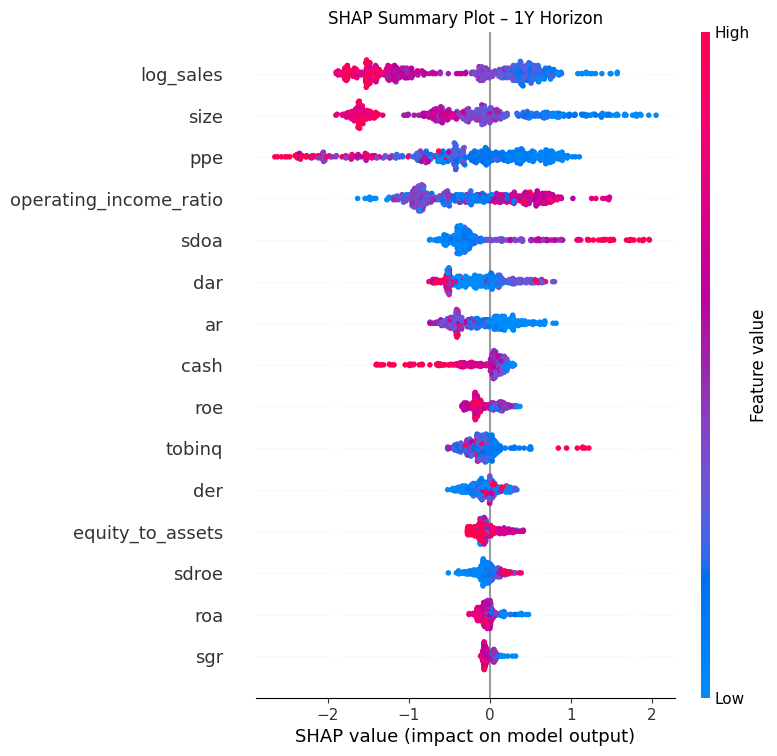


=== TEST 2Y (thr=0.4669) ===
Accuracy : 0.8297
ROC-AUC  : 0.9045
PR-AUC   : 0.7153
Confusion matrix:
 [[192  17]
 [ 30  37]]
Type I Error : 0.4478
Type II Error: 0.0813
Recall      : 0.5522


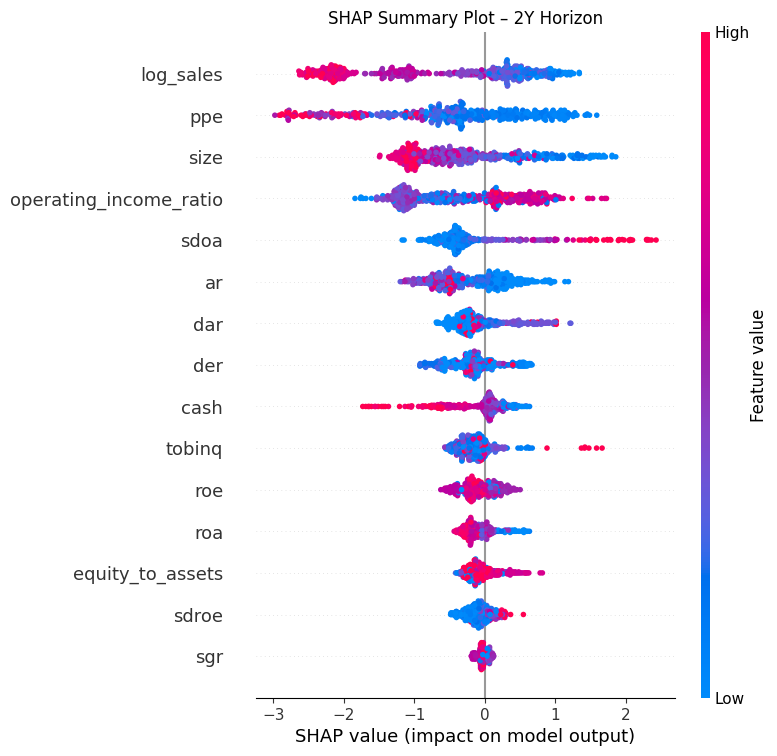


=== TEST 3Y (thr=0.5101) ===
Accuracy : 0.8174
ROC-AUC  : 0.8947
PR-AUC   : 0.6939
Confusion matrix:
 [[156  18]
 [ 24  32]]
Type I Error : 0.4286
Type II Error: 0.1034
Recall      : 0.5714


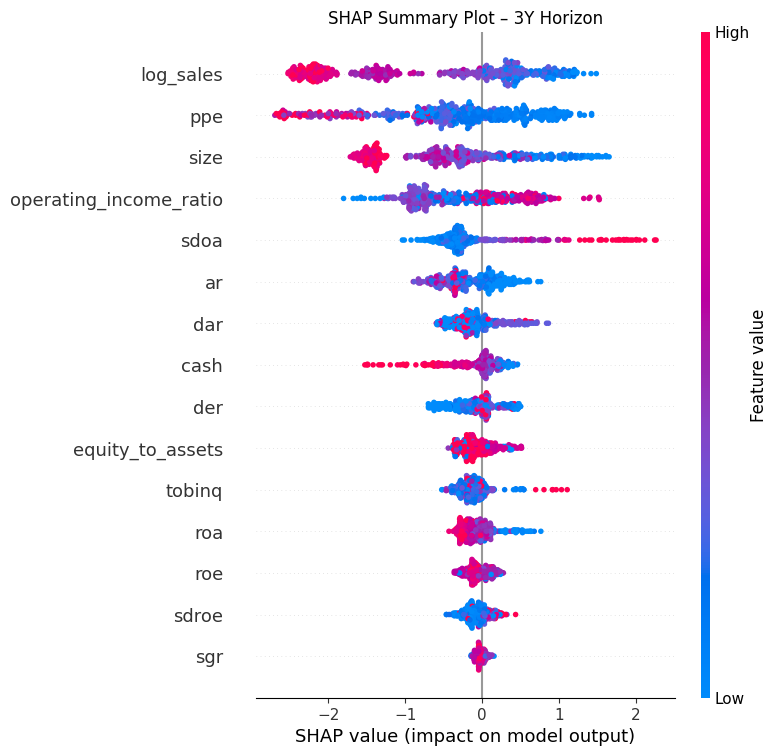


=== TEST 4Y (thr=0.4348) ===
Accuracy : 0.8261
ROC-AUC  : 0.9044
PR-AUC   : 0.7459
Confusion matrix:
 [[120  19]
 [ 13  32]]
Type I Error : 0.2889
Type II Error: 0.1367
Recall      : 0.7111


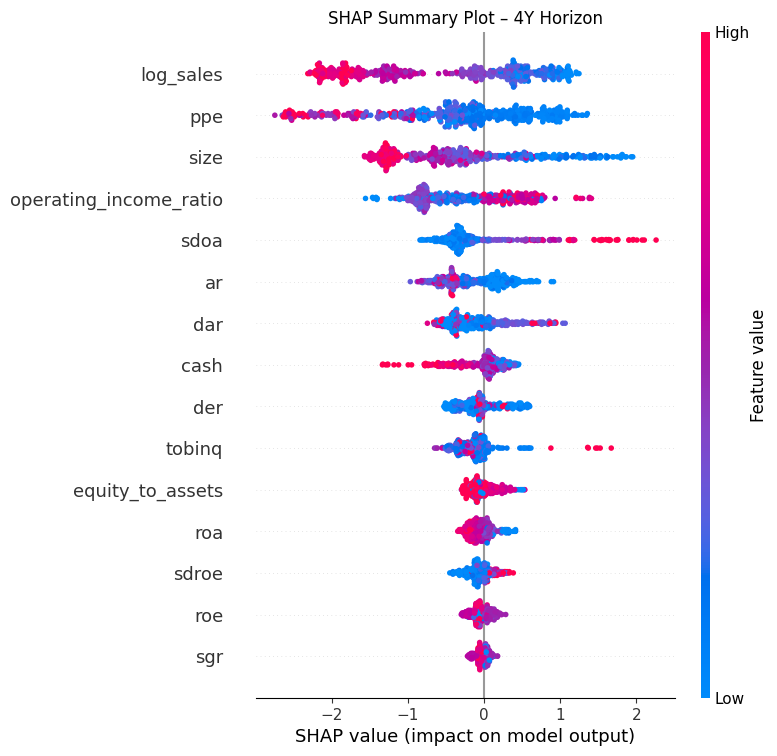


=== TEST 5Y (thr=0.5271) ===
Accuracy : 0.7826
ROC-AUC  : 0.8829
PR-AUC   : 0.6793
Confusion matrix:
 [[90 14]
 [16 18]]
Type I Error : 0.4706
Type II Error: 0.1346
Recall      : 0.5294


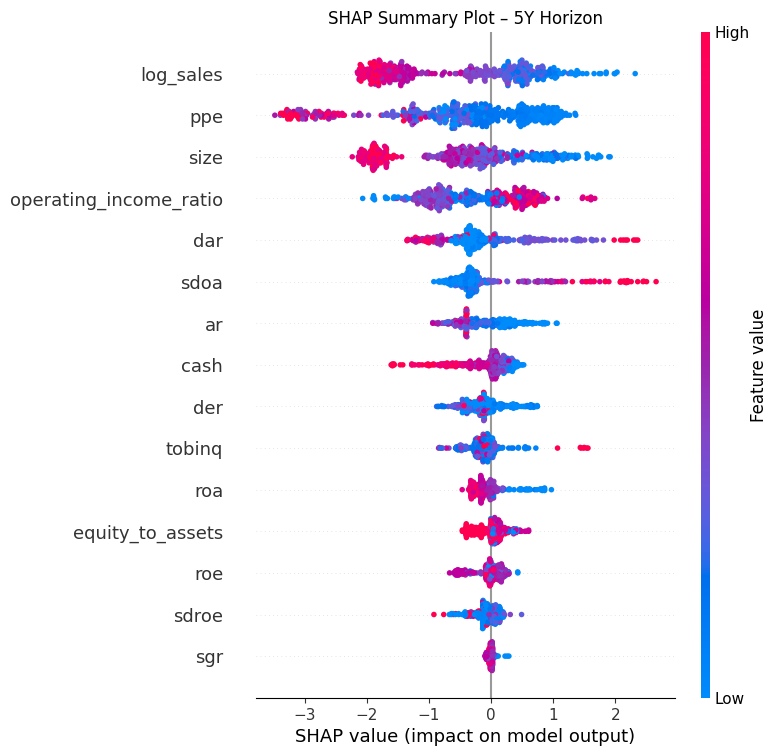

In [9]:
# ============================
# Evaluate and SHAP Plotting
# ============================

horizon_to_evaluate = 3
for h in [1, 2, 3, 4, 5]:
    evaluate_xgb_model(models[h])
    plot_shap_for_horizon(models[h], feature_cols)

Generating SHAP bar plot for 1Y horizon


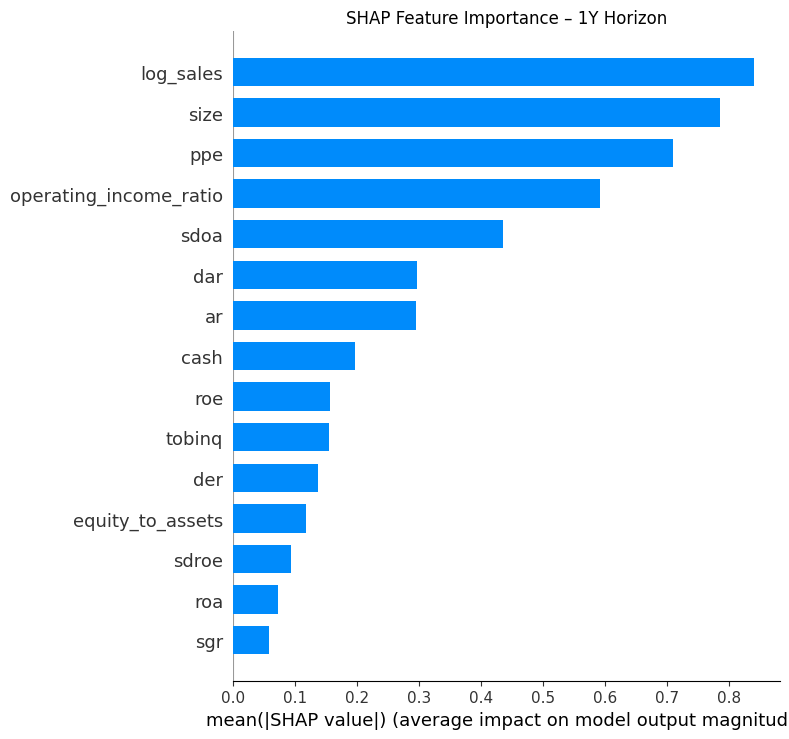

Generating SHAP bar plot for 2Y horizon


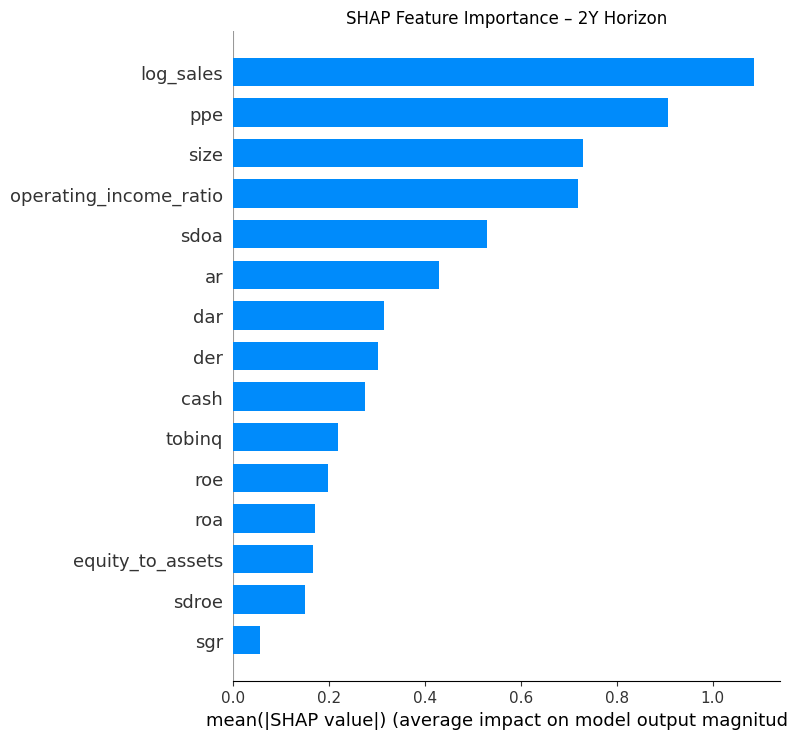

Generating SHAP bar plot for 3Y horizon


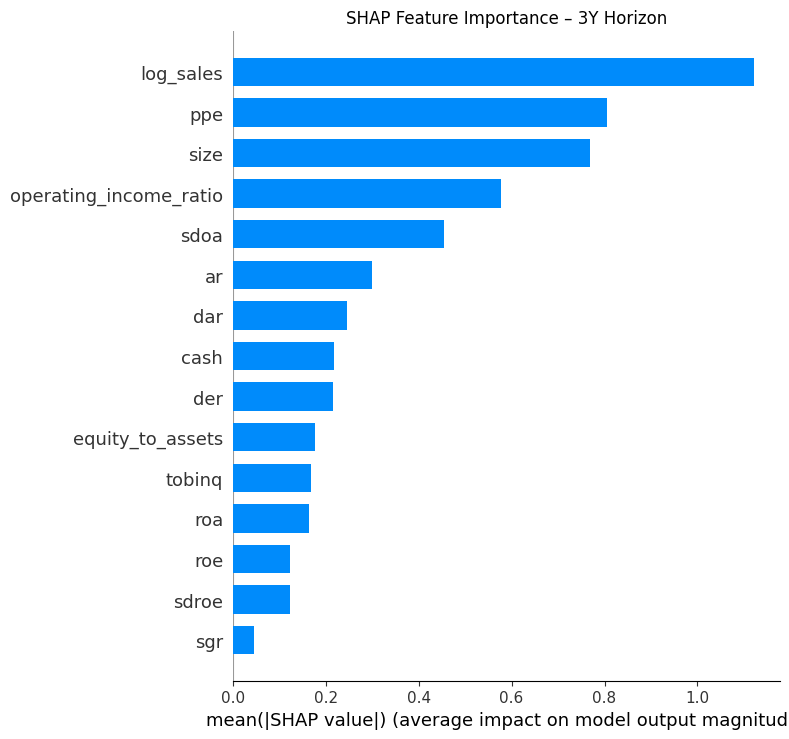

Generating SHAP bar plot for 4Y horizon


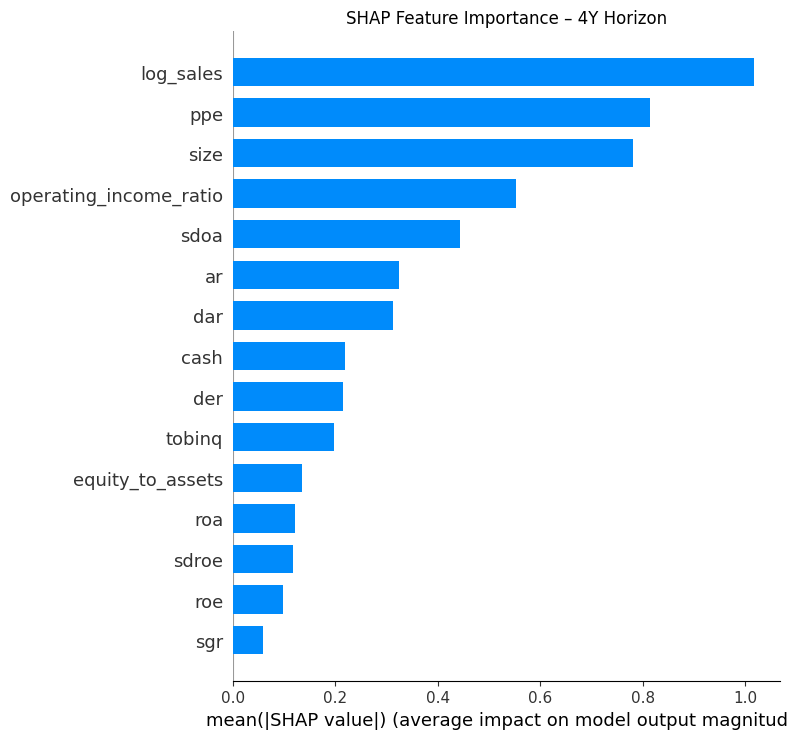

Generating SHAP bar plot for 5Y horizon


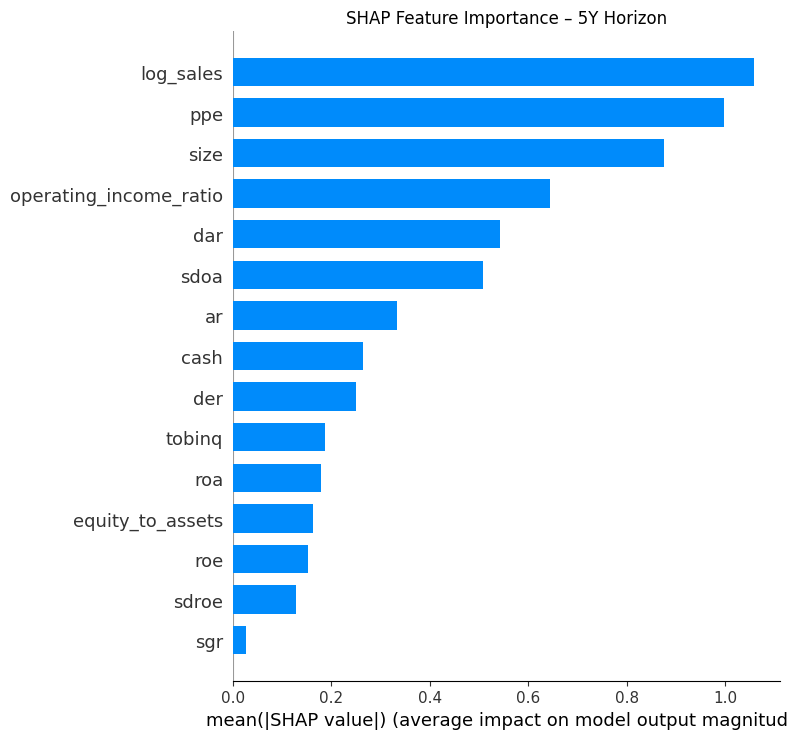

In [10]:
# ============================
# SHAP Feature Importance Bar Plot (Per Horizon)
# ============================

import shap
import matplotlib.pyplot as plt
import xgboost as xgb

for h in [1, 2, 3, 4, 5]:
    print(f"Generating SHAP bar plot for {h}Y horizon")

    booster = models[h]["booster"]
    X_train_h = models[h]["X_train"]

    # sampling
    X_shap = X_train_h.sample(
        n=min(500, len(X_train_h)),
        random_state=42
    )

    dshap = xgb.DMatrix(X_shap)

    explainer = shap.TreeExplainer(booster)
    shap_values = explainer.shap_values(dshap)

    plt.figure()
    shap.summary_plot(
        shap_values,
        X_shap,
        feature_names=feature_cols,
        plot_type="bar",
        show=False
    )
    plt.title(f"SHAP Feature Importance – {h}Y Horizon")
    plt.tight_layout()
    plt.show()


In [ ]:
# ============================
# 4. Train–Val–Test split and Training Horizon Based -- OLD
# ============================

import xgboost as xgb

# Split Training and Validation year of data
TRAIN_END_YEAR = 2019
VAL_END_YEAR = 2021

results = []

for h in [1, 2, 3, 4, 5]:
    print(f"\n===== Horizon {h}Y =====")

    df_hh = df_h.dropna(subset=[f"distress_{h}y"]).copy()
    y = df_hh[f"distress_{h}y"].astype(int)
    X = df_hh[feature_cols]

    # time-based split
    train_mask = df_hh["calendar_year"] <= TRAIN_END_YEAR
    val_mask   = (df_hh["calendar_year"] > TRAIN_END_YEAR) & \
                 (df_hh["calendar_year"] <= VAL_END_YEAR)
    test_mask  = df_hh["calendar_year"] > VAL_END_YEAR

    X_train, y_train = X[train_mask], y[train_mask]
    X_val, y_val     = X[val_mask], y[val_mask]
    X_test, y_test   = X[test_mask], y[test_mask]

    # DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval   = xgb.DMatrix(X_val, label=y_val)
    dtest  = xgb.DMatrix(X_test, label=y_test)

    # scale_pos_weight
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    # RANDOM SEARCH
    best = {"pr": -1}

    for i in range(20):  # cukup 20
        params = {
            "objective": "binary:logistic",
            "eval_metric": "logloss",
            "seed": 42,
            "tree_method": "hist",
            "scale_pos_weight": scale_pos_weight,

            "eta": random.choice([0.01, 0.03, 0.05]),
            "max_depth": random.choice([3, 4, 5]),
            "min_child_weight": random.choice([1, 3]),
            "subsample": random.choice([0.8, 1.0]),
            "colsample_bytree": random.choice([0.6, 0.8]),
            "lambda": random.choice([0.5, 1.0]),
            "gamma": random.choice([0.0, 0.5]),
        }

        booster = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=3000,
            evals=[(dtrain, "train"), (dval, "val")],
            early_stopping_rounds=200,
            verbose_eval=False
        )

        proba_val = predict_best(booster, dval)
        pr = average_precision_score(y_val, proba_val)

        if pr > best["pr"]:
            best = {
                "pr": pr,
                "params": params,
                "best_iter": booster.best_iteration
            }

    booster = xgb.train(
        params=best["params"],
        dtrain=dtrain,
        num_boost_round=5000,
        evals=[(dtrain, "train"), (dval, "val")],
        early_stopping_rounds=200,
        verbose_eval=False
    )

    # Threshold Tuning pakai VAL (0,75)
    proba_val = predict_best(booster, dval)
    thr_df = build_threshold_table(y_val, proba_val)
    chosen_thr = thr_df[thr_df["recall"] >= 0.75].iloc[-1]["threshold"]

    print("Chosen threshold:", chosen_thr)

    # == Evaluate TEST ==
    metrics = eval_split(
        f"TEST {h}Y",
        booster,
        dtest,
        y_test,
        thr=chosen_thr
    )

    metrics["horizon"] = h
    results.append(metrics)

display(results)



import pandas as pd

results_df = pd.DataFrame(results).sort_values("horizon")
results_df

In [ ]:
# ============================
# SHAP Summary Plot -- OLD
# ============================

import shap

# Ambil sample
X_shap = X_train.sample(
    n=min(1000, len(X_train)),
    random_state=42
)

explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_shap)

plt.figure()
shap.summary_plot(
    shap_values,
    X_shap,
    feature_names=feature_cols,
    show=False
)
plt.title(f"SHAP Summary Plot – {h}Y Horizon")
plt.tight_layout()
plt.show()